In [1]:
import torch
import scanpy as sc
import numpy as np
import scvi
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler

import mplscience

mplscience.available_styles()
mplscience.set_style(reset_current=True)
plt.rcParams['legend.scatterpoints'] = 1 

Global seed set to 0


['default', 'despine']


In [2]:
print(scvi.__version__)
print(sc.__version__)

0.17.1
1.9.1


In [3]:
output_dir = "."

In [4]:
adata = sc.read_h5ad("/lustre/groups/ml01/workspace/moscot_paper/pancreas/pancreas_multiome_2022_processed.h5ad")

In [5]:
adata = adata[:,adata.var["modality"]=="GEX"].copy()

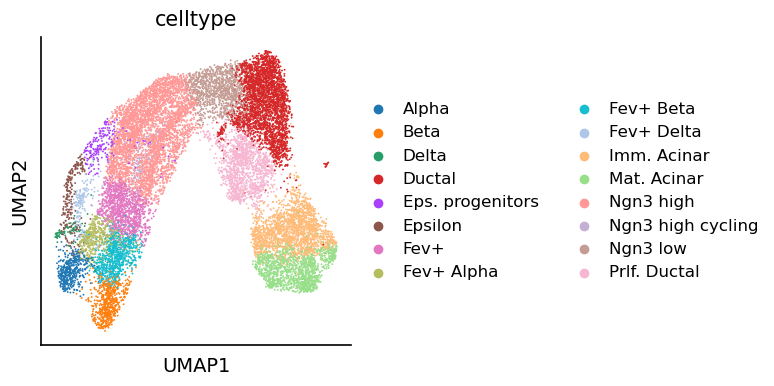

In [6]:
sc.pl.umap(adata, color=["celltype"])

# scVI on GEX space

In [7]:
adata

AnnData object with n_obs × n_vars = 16918 × 14663
    obs: 'n_counts', 'sample', 'n_genes', 'log_genes', 'mt_frac', 'rp_frac', 'ambi_frac', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'S_score', 'G2M_score', 'phase', 'proliferation', 'celltype', 'nCount_peaks', 'nFeature_peaks'
    var: 'modality'
    uns: 'celltype_colors', 'neighbors'
    obsm: 'X_pca', 'X_pca_wsnn', 'X_spca_wsnn', 'X_umap', 'X_umap_ATAC', 'X_umap_GEX', 'X_umap_wsnn', 'lsi_full', 'lsi_red', 'umap', 'umap_ATAC', 'umap_GEX'
    obsp: 'connectivities', 'connectivities_wnn', 'distances', 'distances_wnn'

Following the scVI tutorials, we filter genes as we have relatively few cells compared to the number of genes.

In [8]:
adata.layers["counts"] = adata.X.copy() 
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata # freeze the state in `.raw`

In [9]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="sample",
)

In [10]:
scvi.model.SCVI.setup_anndata(adata, layer="counts")

In [11]:
vae = scvi.model.SCVI(adata)
vae.train()


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|████████████████████████████████████████████| 400/400 [07:23<00:00,  1.11s/it, loss=1.31e+03, v_num=1]


In [12]:
vae


SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: zinb, latent_distribution: normal
Training status: Trained

<AxesSubplot:xlabel='epoch', ylabel='kl_global_train'>

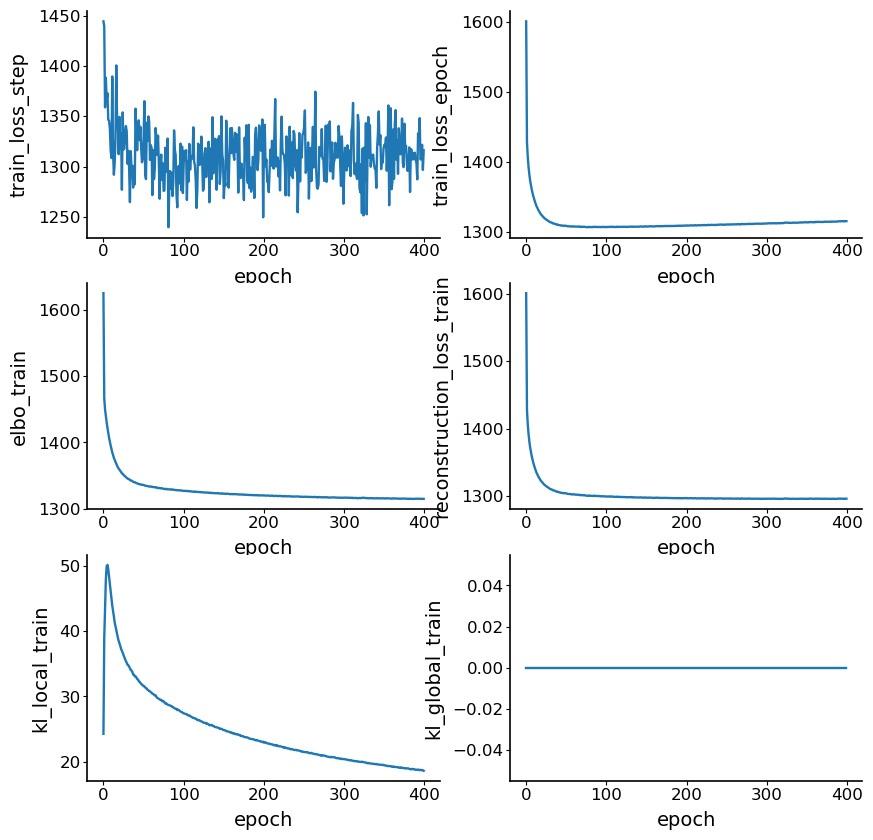

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))

sns.lineplot(data=vae.history['train_loss_step'], x="epoch", y="train_loss_step", ax=axs[0][0])
sns.lineplot(data=vae.history['train_loss_epoch'], x="epoch", y="train_loss_epoch", ax=axs[0][1])
sns.lineplot(data=vae.history['elbo_train'], x="epoch", y="elbo_train", ax=axs[1][0])
sns.lineplot(data=vae.history['reconstruction_loss_train'], x="epoch", y='reconstruction_loss_train', ax=axs[1][1])
sns.lineplot(data=vae.history['kl_local_train'], x="epoch", y='kl_local_train', ax=axs[2][0])
sns.lineplot(data=vae.history['kl_global_train'], x="epoch", y='kl_global_train', ax=axs[2][1])

In [14]:
adata.obsm["X_scVI"]=vae.get_latent_representation()
adata.layers["scvi_normalized"] = vae.get_normalized_expression()


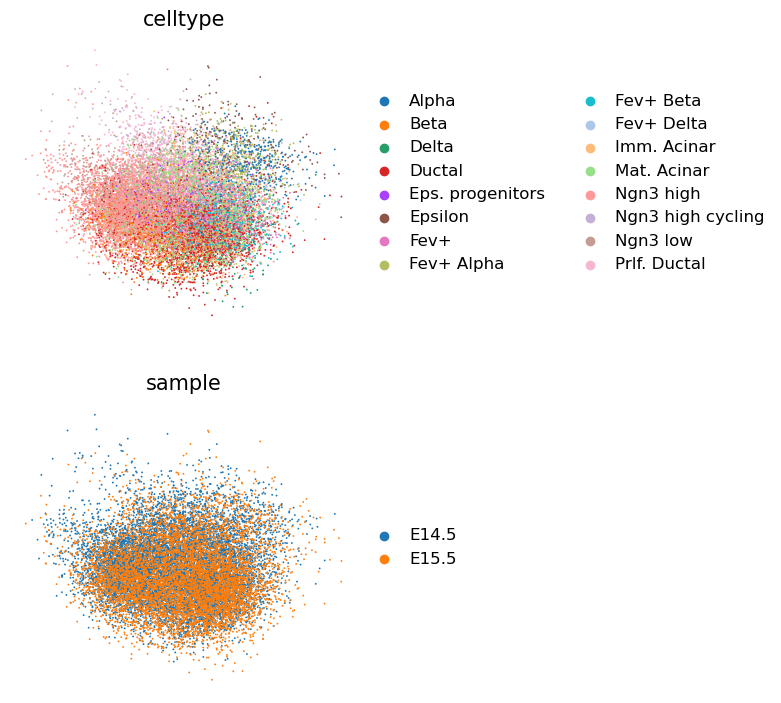

In [15]:
sc.pl.embedding(
    adata,
    basis="X_scVI",
    color=["celltype", "sample"],
    ncols=1,
    frameon=False,
)

In [16]:
fig.figure.savefig(os.path.join(output_dir, 'X_scVI_sample.png'))

In [17]:
sc.pp.neighbors(adata, use_rep="X_scVI", key_added="scVI")
sc.tl.umap(adata, neighbors_key="scVI")

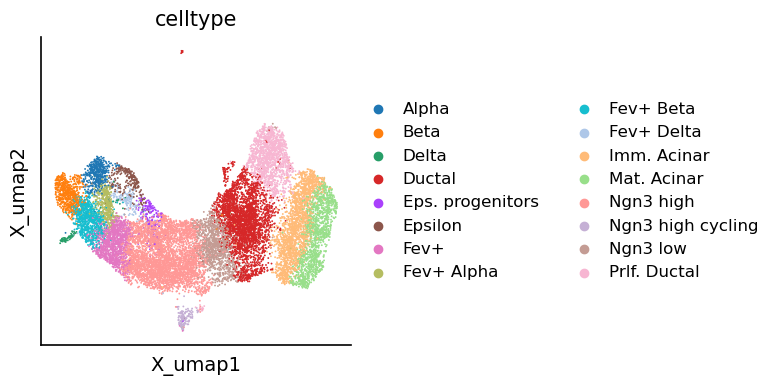

In [18]:
fig = sc.pl.embedding(adata, basis="X_umap", color=["celltype"], show=False)

In [19]:
fig.figure.savefig(os.path.join(output_dir, 'X_scVI_umap_celltype.png'))

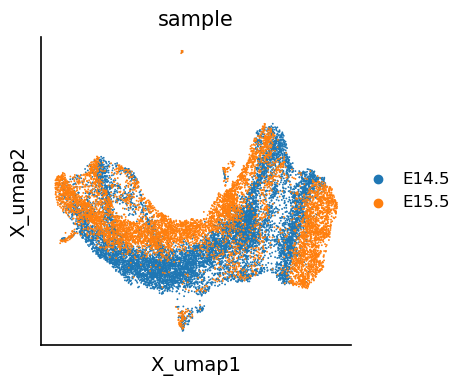

In [20]:
fig = sc.pl.embedding(adata, basis="X_umap", color=["sample"], show=False)

In [21]:
fig.figure.savefig(os.path.join(output_dir, 'X_scVI_umap_sample.png'))

In [22]:
adata.obsm["X_scVI_umap"] = adata.obsm["X_umap"].copy()

In [23]:
vae.save("/lustre/groups/ml01/workspace/moscot_paper/pancreas/embeddings/models/scVI", overwrite=True, save_anndata=True)

# scVI with batch correction

In [24]:
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="sample")

In [25]:
vae = scvi.model.SCVI(adata)
vae.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|████████████████████████████████████████████| 400/400 [06:55<00:00,  1.04s/it, loss=1.31e+03, v_num=1]


<AxesSubplot:xlabel='epoch', ylabel='kl_global_train'>

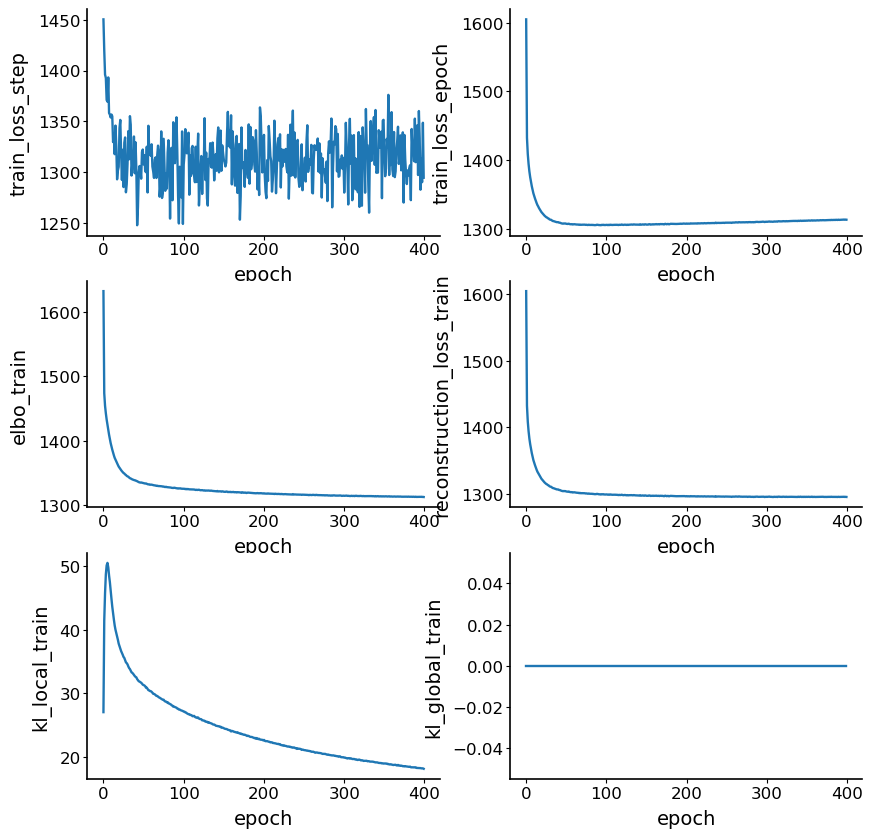

In [26]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))

sns.lineplot(data=vae.history['train_loss_step'], x="epoch", y="train_loss_step", ax=axs[0][0])
sns.lineplot(data=vae.history['train_loss_epoch'], x="epoch", y="train_loss_epoch", ax=axs[0][1])
sns.lineplot(data=vae.history['elbo_train'], x="epoch", y="elbo_train", ax=axs[1][0])
sns.lineplot(data=vae.history['reconstruction_loss_train'], x="epoch", y='reconstruction_loss_train', ax=axs[1][1])
sns.lineplot(data=vae.history['kl_local_train'], x="epoch", y='kl_local_train', ax=axs[2][0])
sns.lineplot(data=vae.history['kl_global_train'], x="epoch", y='kl_global_train', ax=axs[2][1])

In [27]:
adata.obsm["X_scVI_batch_corrected"]=vae.get_latent_representation()
adata.layers["scvi_batch_corrected_normalized"] = vae.get_normalized_expression()


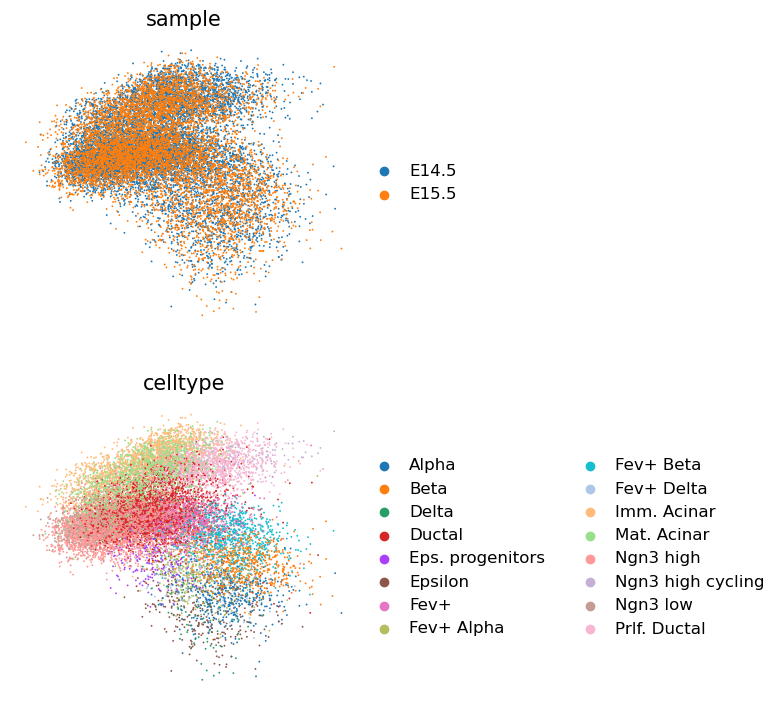

In [28]:
fig = sc.pl.embedding(
    adata,
    basis="X_scVI_batch_corrected",
    color=["sample", "celltype"],
    frameon=False,
    ncols=1,
    show=False
)

In [30]:
sc.pp.neighbors(adata, use_rep="X_scVI_batch_corrected", key_added="scVI_batch_corrected")
sc.tl.umap(adata, neighbors_key="scVI_batch_corrected")

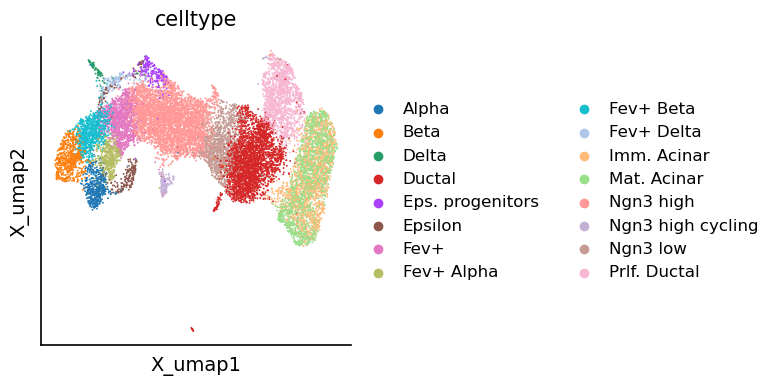

In [31]:
fig = sc.pl.embedding(adata, basis="X_umap", color=["celltype"], show=False)

In [32]:
fig.figure.savefig(os.path.join(output_dir, 'X_scVI_umap_batch_corrected_celltype.png'))

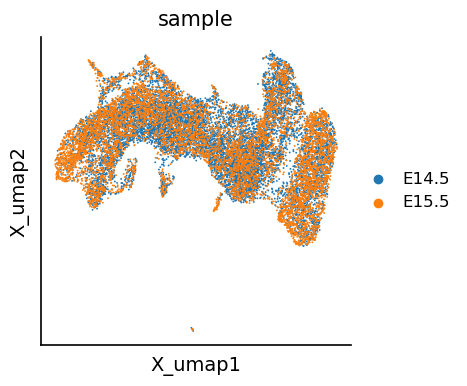

In [33]:
fig = sc.pl.embedding(adata, basis="X_umap", color=["sample"], show=False)

In [34]:
fig.figure.savefig(os.path.join(output_dir, 'X_scVI_umap_batch_corrected_sample.png'))

In [35]:
adata.obsm["X_scVI_umap_batch_corrected"] = adata.obsm["X_umap"].copy()

In [36]:
vae.save("/lustre/groups/ml01/workspace/moscot_paper/pancreas/embeddings/models/scVI_batch_corrected", overwrite=True, save_anndata=True)

In [37]:
adata.write("/lustre/groups/ml01/workspace/moscot_paper/pancreas/embeddings/pancreas_GEX_embeddings.h5ad")